# Switching Linear Regression

Consider the standard linear regression problem, but with a slight twist. First, suppose the data points arrive over time, with $(x_t, y_t) \in \mathbb{R}^{P} \times \mathbb{R}^N$ denoting the $t$-th feature and emission respectively. 
Furthermore, suppose the mapping between features and emissions can change abruptly and without warning. We will model this as a _switching_ linear regression,
\begin{align*}
y_t \mid x_t, z_t &\sim \mathcal{N}(A_{z_t} x_t + b_{z_t}, \Sigma_{z_t}),
\end{align*}
$z_t \in \{1, \ldots, K\}$ is a _discrete latent state_. Finally, assume the discrete states evolve according to a simple Markov model,
\begin{align*}
z_1 & \sim \pi \\
z_{t+1} \mid z_{t} &\sim P_{z_t} & \text{ for } t=1, T-1.
\end{align*}

Our goals are twofold. First, we want to estimate the model parameters $\theta = (\pi, P, \{A_k, b_k, \Sigma_k\}_{k=1}^K)$ -- the weights, biases, and covariance matrices for each discrete state, as well as the intial distribution and transition matrix -- by maximizing the marginal log likelihood,
\begin{align*}
\mathcal{L}(\theta) &= 
\log p(y_{1:T}; x_{1:T}, \theta) \\
&= \log \sum_{z_{1:T}} p(y_{1:T}, z_{1:T}; x_{1:T}, \theta).
\end{align*}
Second, we want to find the most likely discrete latent states are each point in time.

The solution is to recognize that this switching linear regression model is really a hidden Markov model (HMM), but unlike typical HMMs, this one takes covariates. `SSM` models allow inputs (aka covariates) to be passed in as optional keyword arguments. The `LinearRegressionHMM` takes a time series of covariates and implements exactly this switching linear regression model. This notebook shows how to use the `LinearRegressionHMM` to solve the switching linear regression problems described above.


In [1]:
import jax.numpy as jnp
import jax.random as jr

from itertools import count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

from dynamax.hmm.models import LinearRegressionHMM

In [2]:
# First set some global constants
num_states = 2
emission_dim = 3
covariate_dim = 2
num_timesteps = 1000

# Set up an iterator to yield JAX PRNGKey's
keys = map(jr.PRNGKey, count())

In [3]:
# Now make a time series of covariates. These are the inputs to the linear regression.
covariates = jnp.column_stack([jnp.cos(2 * jnp.pi * jnp.arange(num_timesteps) / 10),
                               jnp.sin(2 * jnp.pi * jnp.arange(num_timesteps) / 10)])


In [4]:
# Simulate data from a "true" model with randomly initialized parameters
# (Set the noise covariance to a pretty small value though, so the switches are easier to see.)
hmm = LinearRegressionHMM(num_states, covariate_dim, emission_dim)

transition_matrix = 0.9 * jnp.eye(num_states) + 0.1 / (num_states - 1) * (1 - jnp.eye(num_states))
emission_covariances = jnp.tile(0.1 * jnp.eye(emission_dim), (num_states, 1, 1))
true_params, _ = hmm.initialize(next(keys), 
                                transition_matrix=transition_matrix, 
                                emission_covariances=emission_covariances)

# Here we see our first difference from "regular" HMMs: this one takes `covariates` as a keyword argument
true_states, emissions = hmm.sample(true_params, next(keys), num_timesteps, covariates=covariates)

# Compute the marginal log probability of the emissions under the true model
true_lp = hmm.marginal_log_prob(true_params, emissions, covariates=covariates)

(0.0, 100.0)

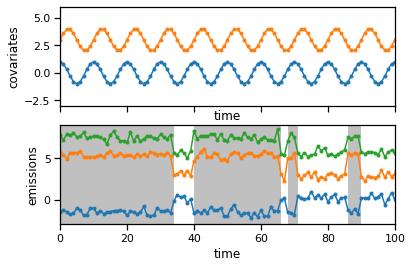

In [5]:
# Plot the covariates and emissions, along with the true states
fig, axs = plt.subplots(2, 1, sharex=True)

offsets = 3 * jnp.arange(covariate_dim)
axs[0].plot(covariates + offsets, '-', marker='.')
axs[0].set_xlim(0, num_timesteps)
axs[0].set_ylim(-3, 3 * covariate_dim)
axs[0].set_ylabel("covariates")
axs[0].set_xlabel("time")


offsets = 3 * jnp.arange(emission_dim)
axs[1].imshow(true_states[None, :],
              extent=(0, num_timesteps, -3, 3 * emission_dim),
              aspect="auto",
              cmap="Greys",
              alpha=0.25)
axs[1].plot(emissions + offsets, '-', marker='.')
axs[1].set_xlim(0, num_timesteps)
axs[1].set_ylim(-3, 3 * emission_dim)
axs[1].set_ylabel("emissions")
axs[1].set_xlabel("time")

# Zoom in on a smaller slice of data
axs[1].set_xlim(0, 100)

100%|██████████| 50/50 [00:01<00:00, 38.50it/s]


(0.0, 50.0)

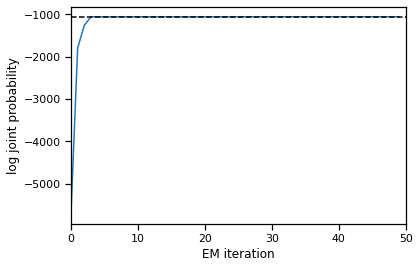

In [6]:
# Now fit another model to the simulated data
test_params, param_props = hmm.initialize(next(keys))

# To fit the model, give it a batch of emissions and a batch of corresponding covariates
test_params, lps = hmm.fit_em(test_params, param_props, emissions, covariates=covariates)

# Plot the log probability over EM iterations
plt.figure()
plt.plot(lps)
plt.plot([0, len(lps)], true_lp * jnp.ones(2), '--k')
plt.xlabel("EM iteration")
plt.ylabel("log joint probability")
plt.xlim([0, len(lps)])

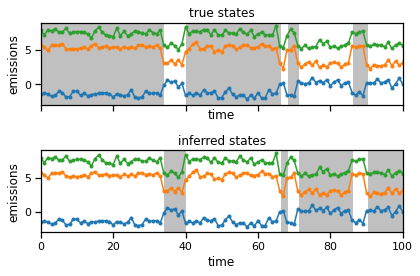

In [7]:
# Compute the most likely states
most_likely_states = hmm.most_likely_states(test_params, emissions, covariates=covariates)

# Compare them to the true states
fig, axs = plt.subplots(2, 1, sharex=True)

for i, states in enumerate([true_states, most_likely_states]):
    offsets = 3 * jnp.arange(emission_dim)
    axs[i].imshow(states[None, :],
                extent=(0, num_timesteps, -3, 3 * emission_dim),
                aspect="auto",
                cmap="Greys",
                alpha=0.25)
    axs[i].plot(emissions + offsets, '-', marker='.')
    axs[i].set_xlim(0, num_timesteps)
    axs[i].set_ylim(-3, 3 * emission_dim)
    axs[i].set_ylabel("emissions")
    axs[i].set_xlabel("time")
    axs[i].set_xlim(0, 100)

axs[0].set_title("true states")
axs[1].set_title("inferred states")
plt.tight_layout()

# Conclusion
Looks like it's working! The log probability of the fitted model matches that of the true model, and the inferred states line up almost exactly with the true states. 

**Exercises:**
1. Use the `test_hmm.emission_distribution` to compute the conditional distribution over emissions under the most likely states and given covariates. Plot the true covariates alongside the predicted mean and covariance.
2. Suppose you had future covariates $x_{T+1:T+L}$ where $L$ is the length of the forecasting window. How could you compute the predictive distribution over future emissions $y_{T+1:T+L}$
3. What type of prior distribution might make sense for the parameters of the emission model, $A_k$, $b_k$, and $\Sigma_k$?